DISCUSSION OF BUSINESS IDEA

Idea Statement:

Sports centres play an important role in a community. The benefits of sports not only help the body, but they also create a less stressed mind. People who exercise regularly are more than twice likely to consider themselves happy. 

Houses that are located closely to newly built sport centres notice increase in property values. Studies have shown that people not only love going to recreation centres, but they are also willing to pay to live closer to one.

Having a sports centre improves the quality of life and empowers a community in general.

Bengaluru is the centre of high-tech industry in India with pleasant weather for most part of the year, hence attracting a huge crowd of people into the city. Given that it is a IT hub, there is an emerging problem of people spending most of their working time sitting. In the recent years, there has been a surge in fitness awareness. 

Running a sport centre in the IT hub trends to be profitable, given the nature of the community.

TARGET AUDIENCE

1. Anyone who is looking to open a sport centre in Bangalore. This analysis will explore Bangalore neighbourhoods and provide probable fits for opening a sport facility along with an analysis of what kind of facility to open
2. Government officials who are looking to uplift a community.
3. Anyone who wants to explore similar Bangalore neighbourhoods (based on the different venues in the area)

DATA THAT WILL BE USED IN THE ANALYSIS

1. A dataset which will give the latitudes and longitudes of all the different wards in the city of Bengaluru
    This data will be used to mark the boundaries of the different wards. The latitude and the longitude data will help in plotting a choropleth map. 
    
2. A dataset to provide the area and population of each of the wards. 
    This data will help in analysing the neighbourhoods in terms of population density and explore the target areas for setting up a sporting centre. The population density can be segmented into 3 categories and a bubble plot can be used to represent the differnt categories. Higher the population density, better the footfall.
    
3. A dataset that gives the different venues in every ward. Foursquare location data will be used for this.
    The venue details and the different categories will help in clustering the areas to find neighbourhoods that are similar to each other. The neighbourhoods will be clustered based on non-sport venues, with the assumption that such characteristics define the development of sports facilities. We will also derive the density of sporting facilites in each neighbourhood. Once we have the clusters defined, a neighbourhood can be chosen such that there is least competition and also one which is similar to the neighbourhood with the higher number of sporting facilities. 
    
The data for Bengaluru wards will be taken from the open city forum.

Import required libraries

In [34]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import the required plotting libraries

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Matplotlib version:  3.0.3
Libraries imported.


Read the GeoJSON data for the various Bengaluru wards

In [35]:
url = 'https://raw.githubusercontent.com/datameet/Municipal_Spatial_Data/master/Bangalore/BBMP.GeoJSON'
blore_json = requests.get(url).json()

From the GeoJSON data, we need the latitude and longitude details for the various wards in Bengaluru. Along with that, we will also read in the area and population details so that the population density for each area can be derived

In [36]:
neighborhoods_data = blore_json['features']

# define the dataframe columns
column_names = ['Neighborhood', 'Ward', 'AreaSqKM', 'Population', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    neighborhood = data['properties']['ASS_CONST1']
    ward = data['properties']['WARD_NAME']
    areasqkm = data['properties']['AREA_SQ_KM']
    lat = data['properties']['LAT']
    lon = data['properties']['LON']
    pop = data['properties']['POP_TOTAL']
    
    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood, 
                                            'Ward': ward,
                                            'AreaSqKM': areasqkm,
                                            'Population': pop,
                                            'Latitude': lat,
                                            'Longitude': lon}, ignore_index=True)
neighborhoods['PopDensity'] = neighborhoods['Population']/neighborhoods['AreaSqKM']

In [37]:
print('Bangalore has {} neighborhoods and {} wards.'.format(
        len(neighborhoods['Neighborhood'].unique()),
        neighborhoods.shape[0]
    )
)

Bangalore has 27 neighborhoods and 198 wards.


Now that we have the longitutes and latitudes of the different wards, let us impose the 198 wards on the Bangalore Map

In [38]:
address = 'Bangalore'

geolocator = Nominatim(user_agent="blore_explorer",timeout=10)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

# create map of Bengaluru using latitude and longitude values
map_blore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Ward']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blore)  
    
map_blore

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


Using the Foursquare location data, let us see how the venues are spread in each of the wards

In [39]:
CLIENT_ID = 'NTM1GC2C0GRDRTHGP3ZFAGSHRKWMTAJNJXY0I4G4G2XJDMKM' # your Foursquare ID
CLIENT_SECRET = 'MVHFSY3A2OQHVLVUNQOCDGPYHRPL0Y3WQAZZG3CFIDFKUAEP' # your Foursquare Secret
VERSION = '20190523' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NTM1GC2C0GRDRTHGP3ZFAGSHRKWMTAJNJXY0I4G4G2XJDMKM
CLIENT_SECRET:MVHFSY3A2OQHVLVUNQOCDGPYHRPL0Y3WQAZZG3CFIDFKUAEP


In [42]:
limit = 100
radius = 1000

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
blore_venues = getNearbyVenues(names=neighborhoods['Ward'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

print('There are {} uniques categories.'.format(len(blore_venues['Venue Category'].unique())))

Chowdeswari Ward
Atturu
Yelahanka Satellite Town
Vijnanapura
Basavanapura
Hudi
Devasandra
A Narayanapura
Vijnana Nagar
HAL Airport
Dodda Bommasandra
Kuvempu Nagar
Jakkuru
Thanisandra
Byatarayanapura
Kodigehalli
Vidyaranyapura
Ullalu
Kengeri
Dodda Bidarakallu
Herohalli
Jalahalli
Rajarajeshwari Nagar
J P Park
Yeshwanthpura
HMT Ward
Lakshmi Devi Nagar
Laggere
Kottegepalya
Shettihalli
Mallasandra
Bagalakunte
T Dasarahalli
Chokkasandra
Peenya Industrial Area
Rajagopal Nagar
Hegganahalli
Vrisabhavathi Nagar
Nandini Layout
Marappana Palya
Nagapura
Mahalakshimpuram
Shakthi Ganapathi Nagar
Shankar Matt
Aramane Nagara
Mattikere
Malleswaram
Rajamahal Guttahalli
Kadu Malleshwar Ward
Subramanya Nagar
Gayithri Nagar
Radhakrishna Temple Ward
Sanjaya Nagar
Ganga Nagar
Hebbala
Vishwanath Nagenahalli
Manorayanapalya
Gangenahalli
Jayachamarajendra Nagar
Kushal Nagar
Kaval Bairasandra
Devara Jeevanahalli
Muneshwara Nagar
Sagayarapuram
S K Garden
Pulikeshinagar
Nagavara
HBR Layout
Banasavadi
Kammanahalli
K

Let us seggregate the data based as sporting and non-sporting venues

In [45]:
venues_minus_sports = ['Indian Restaurant', 'Coffee Shop', 'Resort', 'Electronics Store',
       'Dhaba', 'Hotel', 'Dessert Shop', 'Juice Bar', 'Bus Station', 'Ice Cream Shop',
       'Café', 'Department Store', 'Park', 'Liquor Store',
       'Chinese Restaurant', 'Bakery', 'Pizza Place',
       'Vegetarian / Vegan Restaurant', 'Convenience Store',
       'Shopping Mall', 'Lounge', 'Creperie', 'Multiplex',
       'Movie Theater', 'Toy / Game Store', 'French Restaurant',
       'Italian Restaurant', 'Clothing Store', 'Donut Shop',
       'Bowling Alley', 'Bar', "Men's Store", 'American Restaurant',
       'Fast Food Restaurant', 'Tex-Mex Restaurant', 'Asian Restaurant',
       'Gastropub', 'Dim Sum Restaurant', 'Noodle House',
       'Rajasthani Restaurant', 'Sporting Goods Shop', 
       'Intersection', 'Flea Market', 'Burger Joint', 'Grocery Store',
       'BBQ Joint', 'Breakfast Spot',
       'Bridge', 'Food Truck', 'Supermarket',
       'Farmers Market', 'Airport Terminal', 'Bus Stop', 'Plaza',
       'Snack Place', 'Outdoors & Recreation', 'Spa', 'Sandwich Place',
       'Food Court', 'Brewery', 'Bubble Tea Shop', 'Building',
       'Cosmetics Shop', 'Pharmacy', 'South Indian Restaurant',
       'Historic Site', 'Garden', 'Train Station',
       'Restaurant', 'Concert Hall', 'Indie Movie Theater', 'Lake',
       'Hotel Bar', 'Diner', 'Light Rail Station', 'Fish Market',
       'Market', 'Kerala Restaurant', 'Wine Bar', 'Karnataka Restaurant',
       'Furniture / Home Store', 'Warehouse Store', 'Dance Studio',
       'Scenic Lookout', 'Metro Station', 'ATM', 'Indian Sweet Shop',
       'Fried Chicken Joint', 'Mobile Phone Shop', 'Food Stand',
       'Bus Line', 'Miscellaneous Shop', 'Platform', 'Seafood Restaurant',
       'Performing Arts Venue', 'Boat or Ferry', 'Cafeteria',
       'Auto Garage', 'Shipping Store',
       'Arts & Crafts Store', 'Gourmet Shop', 'Pub', 'Mexican Restaurant',
       'Motorcycle Shop', 'Gas Station', 'Bookstore', 'Thai Restaurant',
       "Women's Store", 'Nightclub', 'Art Gallery', 'Food & Drink Shop',
       'Chaat Place', 'Andhra Restaurant', 'Jewelry Store',
       'Residential Building (Apartment / Condo)', 'Tram Station',
       'Smoke Shop', 'Outdoor Supply Store', 'Bistro',
       'Event Space', 'Pet Store', 
       'Pakistani Restaurant', 'Middle Eastern Restaurant', 'Tea Room',
       'Hyderabadi Restaurant', 'Mediterranean Restaurant',
       'Halal Restaurant', 'Road', 'North Indian Restaurant',
       'Korean Restaurant', 'Falafel Restaurant', 'Steakhouse',
       'Paper / Office Supplies Store', 'Indian Chinese Restaurant',
       'New American Restaurant', 'Hospital', 'Watch Shop',
       'Sports Bar', 'Roof Deck', 'Accessories Store', 'Food',
       'Bed & Breakfast', 'Boutique', 'Bengali Restaurant',
       'Cocktail Bar', 'German Restaurant', 'Outlet Store',
       'Udupi Restaurant', 'Butcher', 'Punjabi Restaurant', 'Music Venue',
       'Chocolate Shop', 'Arcade', 'Vietnamese Restaurant', 'Candy Store',
       'Cupcake Shop', 'Caribbean Restaurant', 'Turkish Restaurant',
       'Bike Shop', 'Multicuisine Indian Restaurant', 'Deli / Bodega',
       'Speakeasy', 'Japanese Restaurant',
       'Capitol Building', 'Parsi Restaurant', 'Cantonese Restaurant', 'Wine Shop',
       'Monument / Landmark', 'Salad Place',
       'Eastern European Restaurant', 'Modern European Restaurant',
       'Afghan Restaurant', 'Trail', 'Bridal Shop', 'Shoe Store',
       'Art Museum',  'Planetarium', 
       'Sushi Restaurant', 'Music Store', 'Paella Restaurant',
       'Gaming Cafe', 'Burrito Place', 'Mughlai Restaurant',
       'Health Food Store', 'Flower Shop',
       'Rest Area', 'Big Box Store', 'Toll Plaza', 'Campground',
       'Airport', 'Lighthouse', 'Moving Target', 'Salon / Barbershop',
       'Travel & Transport', 'Print Shop', 'General Entertainment',
       'Theater', 'Bagel Shop', 'Hookah Bar', 'Botanical Garden',
       'Other Nightlife', 'Southern / Soul Food Restaurant',
       'Garden Center', 'Shop & Service', 'Tailor Shop',
       'Szechuan Restaurant', 'Recreation Center', 'Toll Booth',
       'Tibetan Restaurant', 'Business Service', 'Beer Garden',
       'Hot Dog Joint', 'Comfort Food Restaurant', 'Persian Restaurant',
       'Buffet', 'Boarding House', 'Chettinad Restaurant',
       'Shopping Plaza', 'Irish Pub', 'Kebab Restaurant',
       'Fish & Chips Shop', 'Frozen Yogurt Shop', 'Office',
       'Dumpling Restaurant', 'Dive Bar', 'Neighborhood',
       'Herbs & Spices Store', 'Hotel Pool', 'Camera Store', 'Gift Shop',
       'Mountain']

venues_sports = ['Playground','Athletics & Sports','Field','Gym','Gym / Fitness Center','Gym Pool',
                 'Badminton Court','Yoga Studio','Basketball Court','Gymnastics Gym','Golf Course',
                 'Cricket Ground','Track Stadium','Stadium','Tennis Stadium','Pool Hall','Racetrack',
                 'Soccer Stadium','Hockey Arena','Soccer Field','Pool']

In [46]:
blore_venues_sports = blore_venues.loc[blore_venues['Venue Category'].isin(venues_sports),:]

In [47]:
def sport_venue(category):
    if category in venues_sports:
        return 1
    else:
        return 0

In [48]:
blore_venues['Sports_Venue'] = blore_venues['Venue Category'].apply(sport_venue)

Derive the number of sporting venues in each ward. This will help us analysing the areas with the most and the least number of sporting venues.

In [49]:
blore_sport_venues = blore_venues.groupby('Ward').sum()
blore_sport_group = blore_venues.groupby('Ward')
df_sport_count = blore_sport_group['Sports_Venue'].sum() # Creates a Counts series
df_sport_count = df_sport_count.to_frame().reset_index()
df_sport_count.columns = ['Neighborhood', 'Sporting_Venues_Count']

Clean up the data such that the set of wards from the GeoJSON file is the same as the set from the Venues data

In [50]:
set(neighborhoods['Ward']).difference(set(df_sport_count['Neighborhood']))
set(df_sport_count['Neighborhood']).difference(set(neighborhoods['Ward']))
df_sport_count.loc[197] = ['Dodda Bidarakallu',0]
df_sport_count

,Neighborhood,Sporting_Venues_Count
0,A Narayanapura,0
1,Adugodi,2
2,Agaram,0
3,Agrahara Dasarahalli,1
4,Anjanapura,1
5,Arakere,1
6,Aramane Nagara,3
7,Attiguppe,2
8,Atturu,2
9,Azad Nagar,0


Our next criteria would be to compare the population density for each ward. 
The higher the density, more the footfall.

In [51]:
bins = np.linspace(min(neighborhoods["PopDensity"]), max(neighborhoods["PopDensity"]), 4)
group_names = ['Low', 'Medium', 'High']

neighborhoods['PopDen_binned'] = pd.cut(neighborhoods['PopDensity'], bins, labels=group_names, include_lowest=True )

Convert the population density into a number, so that it can be represented by Bubbles in a bubble plot. The bigger the bubble, the higher the density

In [52]:
def PopDenNo(popden):
    if popden == 'Low':
        return 1
    elif popden == 'Medium':
        return 2
    else:
        return 3

In [53]:
neighborhoods['PopDen_No'] = neighborhoods['PopDen_binned'].apply(PopDenNo)

The density of the sporting facilities in each ward can be represented by a Choropleth map and the population density by bibbles. Superimposing the two plots gives us a straight forward comparison. Let us check how the map would look.

In [54]:
map_blore = folium.Map(location=[latitude, longitude], zoom_start=12)
    
    
map_blore.choropleth(
    geo_data=blore_json,
    data=df_sport_count,
    columns=['Neighborhood', 'Sporting_Venues_Count'],
    key_on='feature.properties.WARD_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sport venues in Bangalore Neighbourhood'
)

for lat, lng, label, pop in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Ward'], neighborhoods['PopDen_No']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=pop*3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blore) 


#Save map

map_blore.save('map_blore_sports_popDen.html')

/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


The next step would be to cluster the wards based on their non-sporting venues. Once we have the cluster for the ward with the most number of sporting facilities, it would give us an idea of the wards where we could have a new sporting facility

In [55]:
#Create dataframe with only non-sport venues

blore_venues_nonsport = blore_venues.loc[blore_venues['Venue Category'].isin(venues_minus_sports),:]
blore_venues_nonsport
blore_venues_nonsport = blore_venues_nonsport.join(neighborhoods.set_index('Ward'), on='Ward')
blore_venues_nonsport.head()

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Sports_Venue,Neighborhood,AreaSqKM,Population,Latitude,Longitude,PopDensity,PopDen_binned,PopDen_No
0,Chowdeswari Ward,13.121709,77.580422,The Dhaba @ Ramanashree California,13.116460,77.579256,Indian Restaurant,0,Yelahanka,7.06,19626.0,13.121709,77.580422,2779.886686,Low,1
1,Chowdeswari Ward,13.121709,77.580422,Starbucks Orion Mall,13.116810,77.575243,Coffee Shop,0,Yelahanka,7.06,19626.0,13.121709,77.580422,2779.886686,Low,1
2,Chowdeswari Ward,13.121709,77.580422,Tawa Tandoor Aur Tadka,13.114152,77.578814,Indian Restaurant,0,Yelahanka,7.06,19626.0,13.121709,77.580422,2779.886686,Low,1
3,Chowdeswari Ward,13.121709,77.580422,Ramanashree California Resort,13.114738,77.577633,Resort,0,Yelahanka,7.06,19626.0,13.121709,77.580422,2779.886686,Low,1
4,Atturu,13.102805,77.560038,LG Brand Shop,13.102462,77.559921,Electronics Store,0,Yelahanka,10.15,24020.0,13.102805,77.560038,2366.502463,Low,1


For this, we use the k-means clustering algorithm, which is a basic unsupervised learning algorithm. In order to run the k-means algorithm, let us encode the various venues based on their categories.

In [56]:
# one hot encoding
blore_nonsport_onehot = pd.get_dummies(blore_venues_nonsport[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
blore_nonsport_onehot['Ward'] = blore_venues_nonsport['Ward'] 

blore_nonsport_onehot

# move neighborhood column to the first column
fixed_columns = [blore_nonsport_onehot.columns[-1]] + list(blore_nonsport_onehot.columns[:-1])
blore_nonsport_onehot = blore_nonsport_onehot[fixed_columns]

blore_nonsport_onehot.head()

,Ward,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Halal Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hyderabadi Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Other Nightlife,Outdoor Supply Store,Outdoors & Recreation,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parsi Restaurant,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Platform,Plaza,Print Shop,Pub,Punjabi Restaurant,Rajasthani Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tailor Shop,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toll Booth,Toll Plaza,Toy / Game Store,Trail,Train Station,Tram Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Women's Store
0,Chowdeswari Ward,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Chowdeswari Ward,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [57]:
blore_nonsport_grouped = blore_nonsport_onehot.groupby('Ward').mean().reset_index()

In [62]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Ward'] = blore_nonsport_grouped['Ward']

for ind in np.arange(blore_nonsport_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blore_nonsport_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A Narayanapura,Pizza Place,Vegetarian / Vegan Restaurant,Bus Station,Grocery Store,Dessert Shop,Department Store,Burger Joint,Falafel Restaurant,Donut Shop,Event Space
1,Adugodi,Indian Restaurant,Café,Lounge,Coffee Shop,Liquor Store,Dessert Shop,Ice Cream Shop,Donut Shop,Bookstore,Juice Bar
2,Agaram,Lounge,Café,Indian Restaurant,Furniture / Home Store,Chinese Restaurant,Food Court,Hotel,Fast Food Restaurant,Intersection,Restaurant
3,Agrahara Dasarahalli,Indian Restaurant,Fast Food Restaurant,Department Store,Snack Place,Bus Station,Ice Cream Shop,Juice Bar,Toll Plaza,Metro Station,Asian Restaurant
4,Anjanapura,Snack Place,Campground,Women's Store,Dive Bar,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant


In [72]:
# set number of clusters
kclusters = 3

blore_nonsport_grouped_clustering = blore_nonsport_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(blore_nonsport_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 1, 2, 1, 1, 1, 1, 2, 1], dtype=int32)

In [73]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

blore_nonsport_merged = blore_venues_nonsport

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
blore_nonsport_merged = blore_nonsport_merged.join(neighborhoods_venues_sorted.set_index('Ward'), on='Ward')

Let us now represent the clusters onto the map we had generated earlier, on top of the choropleth map (with the density of sporting facilities) and the bubbles representing the different population densities

In [74]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_clusters.choropleth(
    geo_data=blore_json,
    data=df_sport_count,
    columns=['Neighborhood', 'Sporting_Venues_Count'],
    key_on='feature.properties.WARD_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sport venues in Bangalore Neighbourhood'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, pop, popbin in zip(blore_nonsport_merged['Ward Latitude'], blore_nonsport_merged['Ward Longitude'], blore_nonsport_merged['Ward'], blore_nonsport_merged['Cluster Labels'], blore_nonsport_merged['PopDen_No'], blore_nonsport_merged['PopDen_binned']):
    label = folium.Popup(str(poi) + '- Cluster ' + str(cluster) + '-' + popbin, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=pop*3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


map_clusters.save('map_blore_nonsports_clusters.html')

/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Now that we know which area to choose, based on the population density and the number of sport facilities, let us see what type of facilites are most favoured by the Bengaluru crowd. This will indicate what facilities our new sport complex should have

In [67]:
sports_group = blore_venues_sports.groupby('Ward')
sport_category_group = blore_venues_sports.groupby(['Venue Category'])
sport_category_group.head()
category_count = sport_category_group['Ward'].count() # Creates a Counts series
category_count = category_count.to_frame().reset_index()
category_count
category_count.columns = ['Category','Count']
category_count.set_index('Category', inplace = True)
print(category_count)

                      Count
Category                   
Athletics & Sports        5
Badminton Court           3
Basketball Court          4
Cricket Ground            1
Field                     2
Golf Course               3
Gym                      51
Gym / Fitness Center     25
Gym Pool                  6
Gymnastics Gym            1
Hockey Arena              1
Playground                9
Pool                      4
Pool Hall                 1
Racetrack                 4
Soccer Field              5
Soccer Stadium            1
Stadium                   3
Tennis Stadium            2
Track Stadium             1
Yoga Studio               2


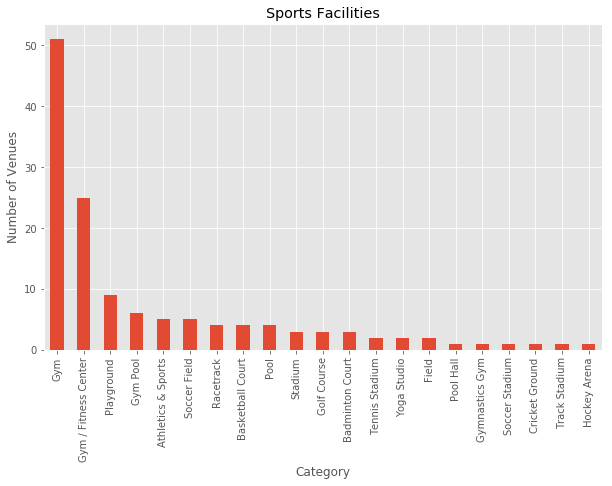

In [68]:
#  plot data
category_count_sorted = category_count.sort_values('Count', ascending=False)
category_count_sorted.plot(kind='bar', figsize=(10, 6), legend = None)

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Sports Facilities') # add title to the plot

plt.show()